#### **Vanishing Gradient with Sigmoid**
---

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import string
import random

import os
from PIL import Image
import cv2

import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

#### Import jeu de données

In [4]:
class Chars74kDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.samples = []
        self.transforms = transforms
        for cls in sorted(os.listdir(root_dir)):
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for fname in os.listdir(cls_dir):
                    if fname.lower().endswith('.png'):
                        self.samples.append((os.path.join(cls_dir, fname), cls))
        self.classes = sorted({label for _, label in self.samples})
        self.cls2idx = {cls: (idx+1) for idx, cls in enumerate(self.classes)}
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, i):
        path, cls = self.samples[i]
        img = Image.open(path).convert("L")
        
        if self.transforms:
            img = self.transforms(img)

        label = self.cls2idx[cls]
        return img, label

In [9]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x < 0.7).float())
])

dataset = Chars74kDataset('data/Chars74k/EnglishImg', transforms=transform)

In [10]:
all_labels = [dataset[i][1] for i in range(len(dataset))]
all_indices = np.arange(len(dataset))

np.random.seed(42)
np.random.shuffle(all_indices)

n_val = int(len(dataset) * 0.2)
val_idx   = all_indices[:n_val]
train_idx = all_indices[n_val:]

train_ds = Subset(dataset, train_idx)
val_ds   = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128, shuffle=False)

#### **Visualisation**
---

In [11]:
characters = list(string.digits + string.ascii_uppercase + string.ascii_lowercase)
class_names = {i + 1: char for i, char in enumerate(characters)}

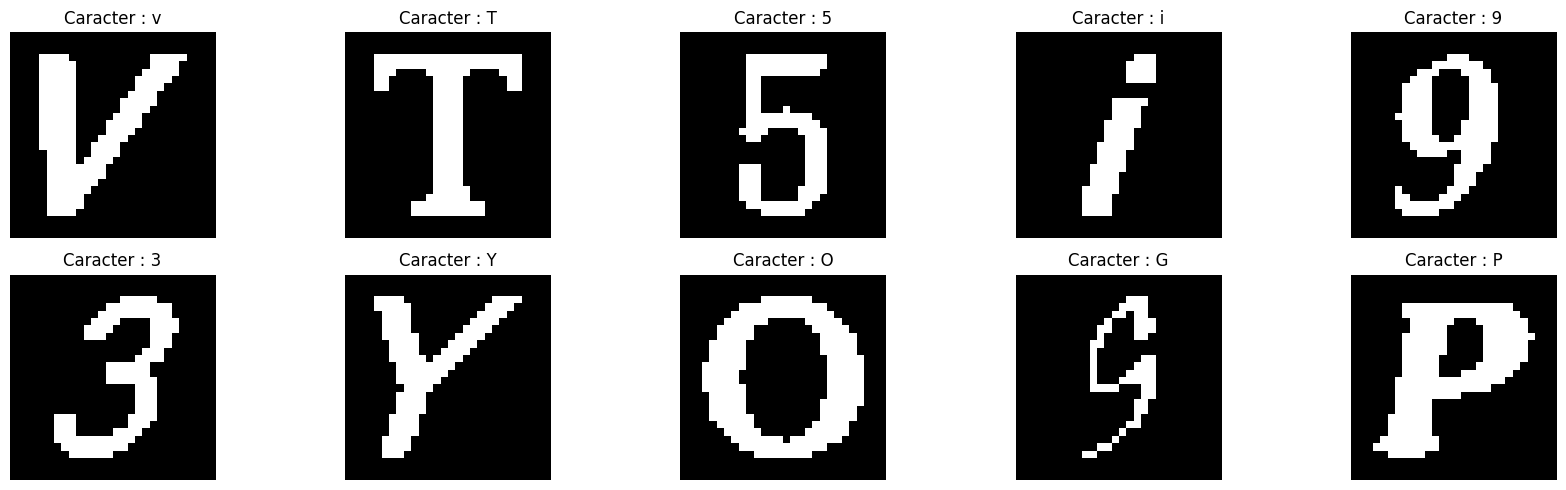

In [12]:
def show_random_chars(dataset, n_rows=2, n_cols=5, class_names=None):
    n = n_rows * n_cols
    indices = random.sample(range(len(dataset)), n)
    images, labels = zip(*[dataset[i] for i in indices])

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5*n_cols, 2.5*n_rows))

    for ax, img, label in zip(axes.flatten(), images, labels):
        if isinstance(img, torch.Tensor):
            img_np = img.squeeze().numpy()
        else:
            img_np = img
        ax.imshow(img_np, cmap='gray')
        ax.axis('off')
        if class_names:
            ax.set_title(f"Caracter : {class_names[label]}")
        else:
            ax.set_title(f'Label: {label}')
    plt.tight_layout()
    plt.show()

show_random_chars(dataset, class_names=class_names)

#### **Model definition and Training**
---

In [ ]:
class VGGLikeNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Bloc 1
        self.conv1_1 = nn.Conv2d(1, 2, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(2, 4, kernel_size=3, padding=1)
        self.sigmoid1_1 = nn.Sigmoid()
        self.pool1   = nn.MaxPool2d(2, 2)

        # Bloc 2
        self.conv2_1 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.sigmoid2_1 = nn.Sigmoid()
        self.pool2   = nn.MaxPool2d(2, 2)

        # Classifieur
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(16 * 7 * 7, 256)
        self.relu_fc = nn.ReLU()
        self.fc2     = nn.Linear(256, 128)
        self.out     = nn.Linear(128, num_classes)

    def forward(self, x):
        activations = {}

        x = self.conv1_1(x); activations['conv1_1'] = x
        x = self.conv1_2(x); activations['conv1_2'] = x
        x = self.sigmoid1_1(x); activations['sigmoid1_1'] = x
        x = self.pool1(x);   activations['pool1']   = x

        x = self.conv2_1(x); activations['conv2_1'] = x
        x = self.conv2_2(x); activations['conv2_2'] = x
        x = self.sigmoid2_1(x); activations['sigmoid2_1'] = x
        x = self.pool2(x);   activations['pool2']   = x

        x = self.flatten(x);         activations['flatten'] = x
        x = self.fc1(x);             activations['fc1']     = x
        x = self.relu_fc(x);         activations['relu_fc1']= x
        x = self.fc2(x);             activations['fc2']     = x
        x = self.relu_fc(x);         activations['relu_fc2']= x
        logits = self.out(x);        activations['out']     = logits

        return logits, activations

In [ ]:
## Parametrisation

device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model  = VGGLikeNN(63).to(device)
optimizer  = optim.SGD(cnn_model.parameters(), lr=8e-3)
criterion  = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/mon_model_cnn_sigmoid1")
epochs     = 30

## Training loop
for epoch in range(epochs):
    
    cnn_model.train()
    train_loss, correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        logits, activations = cnn_model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc  = correct / len(train_loader.dataset)

    # Validation
    cnn_model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = cnn_model(imgs)
            loss = criterion(logits, labels)

            val_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc  = correct        / len(val_loader.dataset)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | "
            f"train_loss: {train_loss:.4f} — train_acc: {train_acc:.4f} | "
            f"val_loss:   {val_loss:.4f} — val_acc:   {val_acc:.4f}")

    # Test Tensorboard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val",   val_loss,   epoch)
    writer.add_scalar("Acc/Train",  train_acc,  epoch)
    writer.add_scalar("Acc/Val",    val_acc,    epoch)

    for name, param in cnn_model.named_parameters():
        writer.add_histogram(name, param.cpu(), epoch)
        if param.grad is not None:
            writer.add_histogram(f"{name}_grad", param.grad.cpu(), epoch)

    imgs, _ = next(iter(val_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        _, activations = cnn_model(imgs)

    for layer_name, activation in activations.items():
        if activation.ndim == 4:
            featmap = activation[0]
            n_maps  = featmap.size(0)
            for i in range(n_maps):
                img_tensor = featmap[i].unsqueeze(0).cpu()
                writer.add_image(
                    f"Activations/{layer_name}/map_{i}",
                    img_tensor,
                    epoch)

writer.close()

Epoch 5/30 | train_loss: 4.1314 — train_acc: 0.0166 | val_loss:   4.1314 — val_acc:   0.0131
Epoch 10/30 | train_loss: 4.1288 — train_acc: 0.0164 | val_loss:   4.1289 — val_acc:   0.0131
Epoch 15/30 | train_loss: 4.1283 — train_acc: 0.0160 | val_loss:   4.1289 — val_acc:   0.0131
Epoch 20/30 | train_loss: 4.1283 — train_acc: 0.0157 | val_loss:   4.1284 — val_acc:   0.0151
Epoch 25/30 | train_loss: 4.1282 — train_acc: 0.0166 | val_loss:   4.1286 — val_acc:   0.0149
Epoch 30/30 | train_loss: 4.1282 — train_acc: 0.0165 | val_loss:   4.1285 — val_acc:   0.0148


- *Suivi des métriques* : le modèle n’apprend pas du tout  
- *Confirmation via TensorBoard* : les poids des couches profondes restent figés  
- *Analyse des gradients* : ces couches souffrent d’une disparition de gradient, d’où l’absence de mise à jour des paramètres  
- *Origine du problème* : la dérivée de la fonction sigmoïde devenant quasi nulle lorsque les activations ne sont pas normalisées  

#### **Avec batchNorm2d**
---

In [23]:
class VGGLikeNN2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Bloc 1
        self.conv1_1 = nn.Conv2d(1, 2, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(2, 4, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(4)
        self.sigmoid1_1 = nn.Sigmoid()
        self.pool1   = nn.MaxPool2d(2, 2)

        # Bloc 2
        self.conv2_1 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.sigmoid2_1 = nn.Sigmoid()
        self.pool2   = nn.MaxPool2d(2, 2)

        # Classifieur
        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(16 * 7 * 7, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu_fc = nn.ReLU(inplace=True)
        self.fc2     = nn.Linear(256, 128)
        self.out     = nn.Linear(128, num_classes)

    def forward(self, x):
        activations = {}

        # --- Bloc 1 ---
        x = self.conv1_1(x); activations['conv1_1'] = x
        x = self.conv1_2(x); activations['conv1_2'] = x
        x = self.bn1(x); activations['bn1'] = x
        x = self.sigmoid1_1(x); activations['sigmoid1_1'] = x
        x = self.pool1(x);   activations['pool1']   = x

        # --- Bloc 2 ---
        x = self.conv2_1(x); activations['conv2_1'] = x
        x = self.conv2_2(x); activations['conv2_2'] = x
        x = self.bn2(x); activations['bn2'] = x
        x = self.sigmoid2_1(x); activations['sigmoid2_1'] = x
        x = self.pool2(x);   activations['pool2']   = x

        # --- Classifieur ---
        x = self.flatten(x);         activations['flatten'] = x
        x = self.fc1(x);             activations['fc1']     = x
        x = self.bn3(x); activations['bn3'] = x
        x = self.relu_fc(x);         activations['relu_fc1']= x
        x = self.fc2(x);             activations['fc2']     = x
        x = self.relu_fc(x);         activations['relu_fc2']= x
        logits = self.out(x);        activations['out']     = logits

        return logits, activations

In [ ]:
## TODO: Training loop as function
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model  = VGGLikeNN2(63).to(device)
optimizer  = optim.SGD(cnn_model.parameters(), lr=8e-3)
criterion  = nn.CrossEntropyLoss()
writer = SummaryWriter("runs/mon_model_cnn_sigmoid2_batchnormed")
epochs     = 30

## Training loop
for epoch in range(epochs):
    
    cnn_model.train()
    train_loss, correct = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        logits, activations = cnn_model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_acc  = correct / len(train_loader.dataset)

    # Validation
    cnn_model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits, _ = cnn_model(imgs)
            loss = criterion(logits, labels)

            val_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc  = correct        / len(val_loader.dataset)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | "
            f"train_loss: {train_loss:.4f} — train_acc: {train_acc:.4f} | "
            f"val_loss:   {val_loss:.4f} — val_acc:   {val_acc:.4f}")

    # Test Tensorboard
    writer.add_scalar("Loss/Train", train_loss, epoch)
    writer.add_scalar("Loss/Val",   val_loss,   epoch)
    writer.add_scalar("Acc/Train",  train_acc,  epoch)
    writer.add_scalar("Acc/Val",    val_acc,    epoch)

    for name, param in cnn_model.named_parameters():
        writer.add_histogram(name, param.cpu(), epoch)
        if param.grad is not None:
            writer.add_histogram(f"{name}_grad", param.grad.cpu(), epoch)

    imgs, _ = next(iter(val_loader))
    imgs = imgs.to(device)
    with torch.no_grad():
        _, activations = cnn_model(imgs)

    for layer_name, activation in activations.items():
        if activation.ndim == 4:
            featmap = activation[0]
            n_maps  = featmap.size(0)
            for i in range(n_maps):
                img_tensor = featmap[i].unsqueeze(0).cpu()
                writer.add_image(
                    f"Activations/{layer_name}/map_{i}",
                    img_tensor,
                    epoch)

writer.close()

Epoch 5/30 | train_loss: 0.9085 — train_acc: 0.7795 | val_loss:   0.8643 — val_acc:   0.7780
Epoch 10/30 | train_loss: 0.6097 — train_acc: 0.8240 | val_loss:   0.6347 — val_acc:   0.8150
Epoch 15/30 | train_loss: 0.5069 — train_acc: 0.8449 | val_loss:   0.5573 — val_acc:   0.8270
Epoch 20/30 | train_loss: 0.4429 — train_acc: 0.8606 | val_loss:   0.5154 — val_acc:   0.8339
Epoch 25/30 | train_loss: 0.3956 — train_acc: 0.8731 | val_loss:   0.4673 — val_acc:   0.8464
Epoch 30/30 | train_loss: 0.3569 — train_acc: 0.8849 | val_loss:   0.4630 — val_acc:   0.8497
